<a href="https://colab.research.google.com/github/yosrahamdi/ImageClassification/blob/master/DeepLearningProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
!pip install kaggle

In [0]:
!mkdir /content/kaggle


In [0]:
!mkdir -p ~/.kaggle

In [0]:
import json
token = {"username":"yosrahamdi","key":"2ccb29980025cc9f65caa5ad164d97af"}
with open('/content/kaggle/kaggle.json', 'w+') as file:
    json.dump(token, file)

In [0]:
!cp /content/kaggle/kaggle.json ~/.kaggle/kaggle.json

In [0]:
!kaggle config set -n path -v /content

- path is now set to: /content


In [0]:
!kaggle competitions download -c ashrae-energy-prediction

 87% 145M/167M [00:03<00:00, 30.7MB/s]
100% 167M/167M [00:04<00:00, 43.5MB/s]
  0% 0.00/2.53M [00:00<?, ?B/s]
100% 2.53M/2.53M [00:00<00:00, 83.4MB/s]
  0% 0.00/1.27M [00:00<?, ?B/s]
100% 1.27M/1.27M [00:00<00:00, 86.0MB/s]
 81% 97.0M/120M [00:03<00:00, 26.8MB/s]
100% 120M/120M [00:03<00:00, 39.6MB/s] 
 87% 77.0M/88.4M [00:01<00:00, 36.7MB/s]
100% 88.4M/88.4M [00:01<00:00, 63.1MB/s]
  0% 0.00/44.5k [00:00<?, ?B/s]
100% 44.5k/44.5k [00:00<00:00, 38.5MB/s]


In [0]:
# unzip dataset
!unzip /content/competitions/ashrae-energy-prediction/sample_submission.csv.zip
!unzip /content/competitions/ashrae-energy-prediction/test.csv.zip
!unzip /content/competitions/ashrae-energy-prediction/train.csv.zip
!unzip /content/competitions/ashrae-energy-prediction/weather_test.csv.zip
!unzip /content/competitions/ashrae-energy-prediction/weather_train.csv.zip

Archive:  /content/competitions/ashrae-energy-prediction/sample_submission.csv.zip
  inflating: sample_submission.csv   
Archive:  /content/competitions/ashrae-energy-prediction/test.csv.zip
  inflating: test.csv                
Archive:  /content/competitions/ashrae-energy-prediction/train.csv.zip
  inflating: train.csv               
Archive:  /content/competitions/ashrae-energy-prediction/weather_test.csv.zip
  inflating: weather_test.csv        
Archive:  /content/competitions/ashrae-energy-prediction/weather_train.csv.zip
  inflating: weather_train.csv       


In [0]:
import gc
import os
import random


import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

path_data = "/content/"
path_train = path_data + "train.csv"
path_test = path_data + "test.csv"
path_building = "/content/competitions/ashrae-energy-prediction/building_metadata.csv"
path_weather_train = path_data + "weather_train.csv"
path_weather_test = path_data + "weather_test.csv"

plt.style.use("seaborn")
sns.set(font_scale=1)

myfavouritenumber = 0
seed = myfavouritenumber
random.seed(seed)

In [0]:
import numpy as np 
import pandas as pd 
import gc

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import matplotlib.patches as patches

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
pd.set_option('max_columns', 150)

py.init_notebook_mode(connected=True)
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go

import os,random, math, psutil, pickle   

In [0]:
df_train = pd.read_csv(path_train)

building = pd.read_csv(path_building)
le = LabelEncoder()
building.primary_use = le.fit_transform(building.primary_use)

weather = pd.read_csv(path_weather_train)

In [0]:
df_train.head()

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01 00:00:00,0.0
1,1,0,2016-01-01 00:00:00,0.0
2,2,0,2016-01-01 00:00:00,0.0
3,3,0,2016-01-01 00:00:00,0.0
4,4,0,2016-01-01 00:00:00,0.0


In [0]:
weather.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,0,2016-01-01 01:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0
3,0,2016-01-01 03:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0
4,0,2016-01-01 04:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6


In [0]:
building.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,0,7432,2008.0,NaN
1,0,1,0,2720,2004.0,NaN
2,0,2,0,5376,1991.0,NaN
3,0,3,0,23685,2002.0,NaN
4,0,4,0,116607,1975.0,NaN


In [0]:
## Function to reduce the DF size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df


In [0]:
df_train = reduce_mem_usage(df_train)
building = reduce_mem_usage(building)

Mem. usage decreased to 289.19 Mb (53.1% reduction)
Mem. usage decreased to  0.02 Mb (74.9% reduction)


# Data visualisation

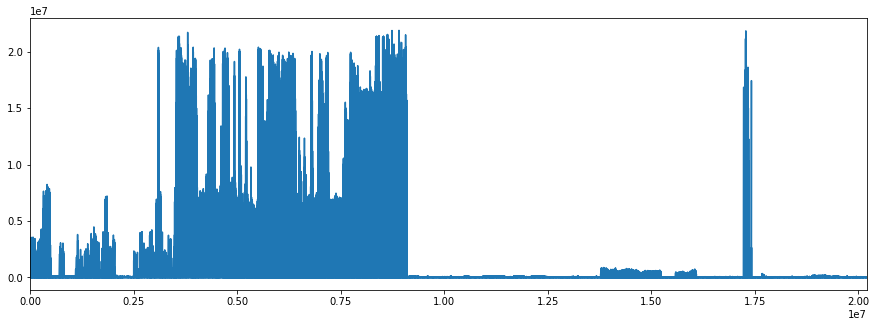

In [0]:
plt.figure(figsize = (15,5))
train_df['meter_reading'].plot()

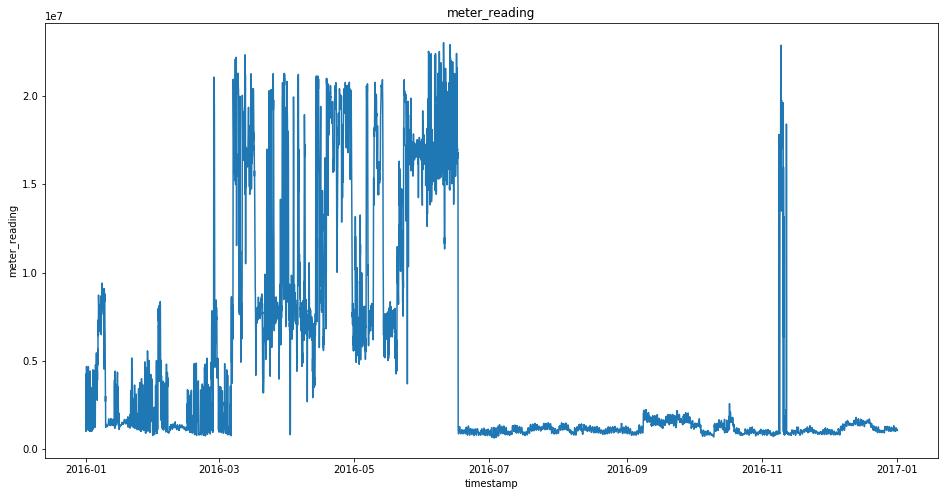

In [0]:
from statsmodels.tsa.seasonal import seasonal_decompose

ts= train_df.groupby(["timestamp"])["meter_reading"].sum()
ts.astype('float')
plt.figure(figsize=(16,8))
plt.title('meter_reading')
plt.xlabel('timestamp')
plt.ylabel('meter_reading')
plt.plot(ts)

In [0]:
def plot_dist_col(column):
    
    fig, ax = plt.subplots(figsize=(10, 10))
    sns.distplot(weather_train_df[column].dropna(), ax=ax).set_title(column, fontsize=16)
    plt.xlabel(column, fontsize=15)
    plt.legend(['train'])
    plt.show()


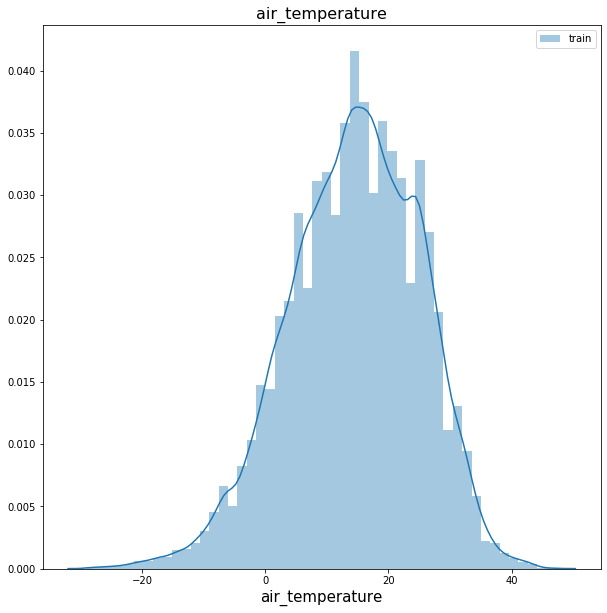

In [0]:
plot_dist_col('air_temperature')

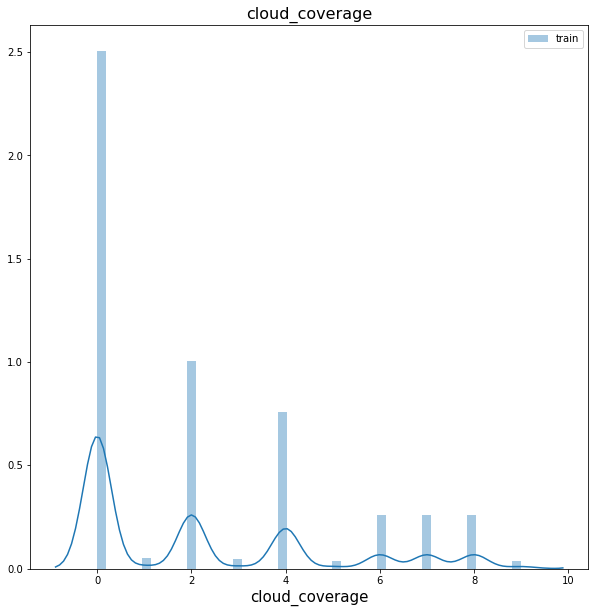

In [0]:
plot_dist_col('cloud_coverage')

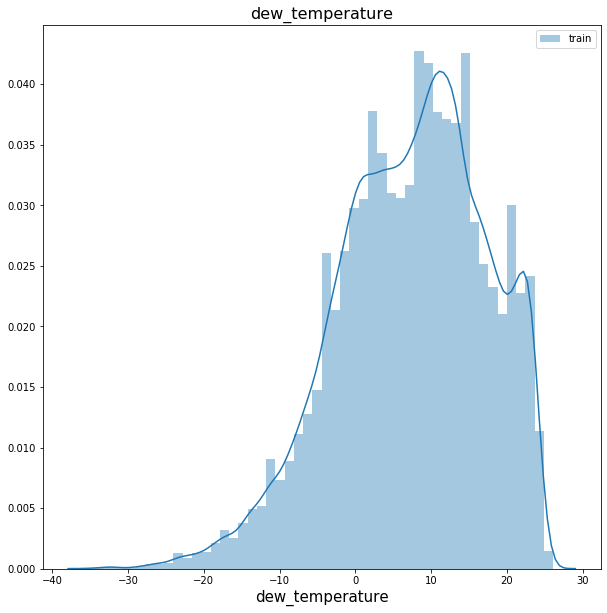

In [0]:
plot_dist_col('dew_temperature')

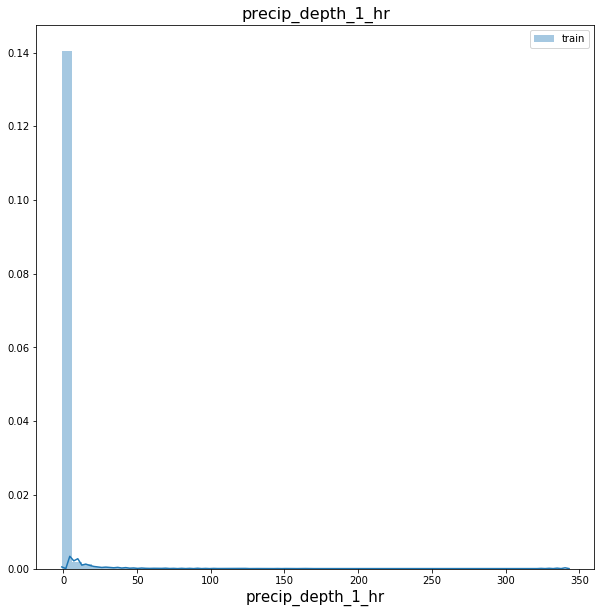

In [0]:
plot_dist_col('precip_depth_1_hr')

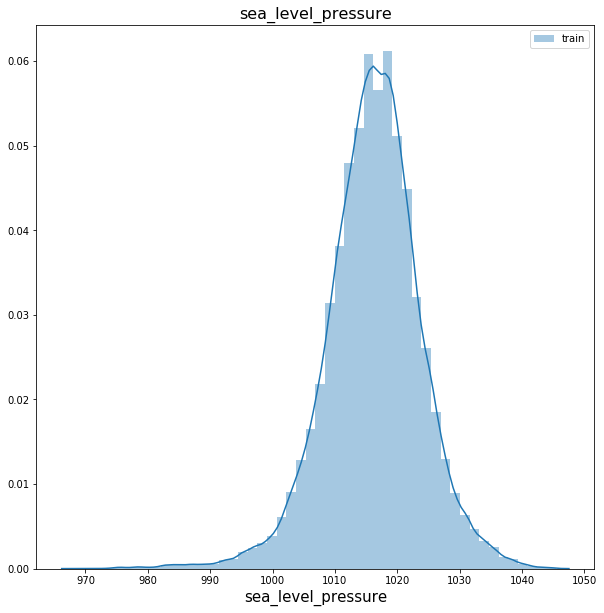

In [0]:
plot_dist_col('sea_level_pressure')

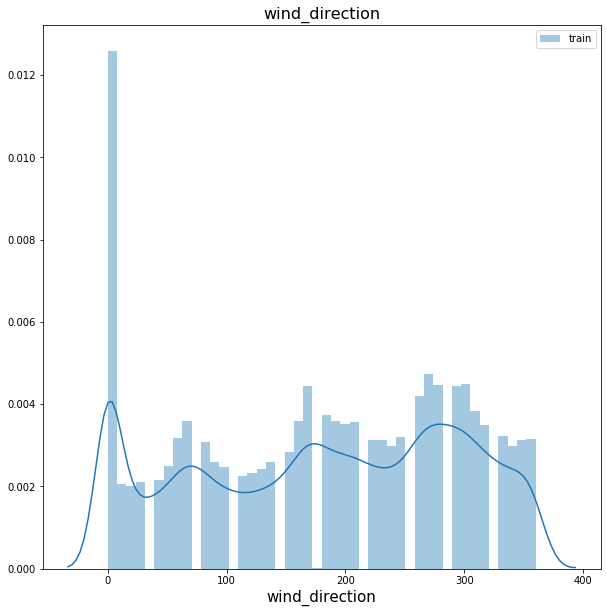

In [0]:
plot_dist_col('wind_direction')

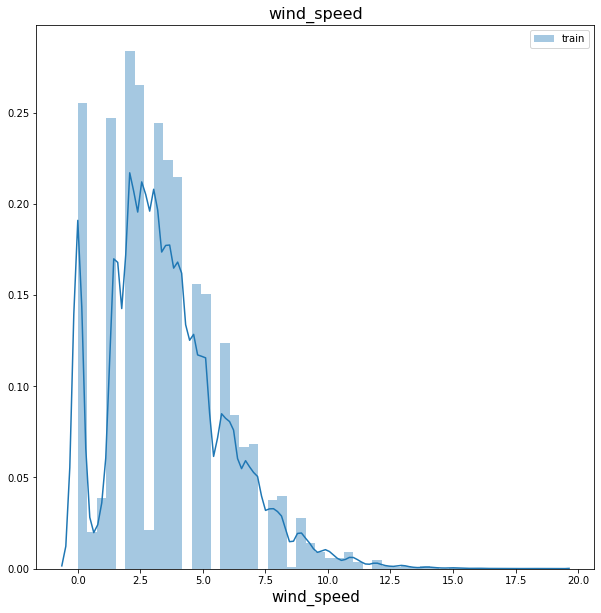

In [0]:
plot_dist_col('wind_speed')

# Data preparation

In [0]:
def missing_statistics(df):    
    statitics = pd.DataFrame(df.isnull().sum()).reset_index()
    statitics.columns=['COLUMN NAME',"MISSING VALUES"]
    statitics['TOTAL ROWS'] = df.shape[0]
    statitics['% MISSING'] = round((statitics['MISSING VALUES']/statitics['TOTAL ROWS'])*100,2)
    return statitics

In [0]:
missing_statistics(weather)

,COLUMN NAME,MISSING VALUES,TOTAL ROWS,% MISSING
0,site_id,0,139773,0.00
1,timestamp,0,139773,0.00
2,air_temperature,55,139773,0.04
3,cloud_coverage,69173,139773,49.49
4,dew_temperature,113,139773,0.08
5,precip_depth_1_hr,50289,139773,35.98
6,sea_level_pressure,10618,139773,7.60
7,wind_direction,6268,139773,4.48
8,wind_speed,304,139773,0.22


In [0]:
import datetime
def fill_weather_dataset(weather_df):

    # Add new Features
    weather_df["datetime"] = pd.to_datetime(weather_df["timestamp"])
    weather_df["day"] = weather_df["datetime"].dt.day
    weather_df["week"] = weather_df["datetime"].dt.week
    weather_df["month"] = weather_df["datetime"].dt.month
    
    # Reset Index for Fast Update
    weather_df = weather_df.set_index(['site_id','day','month'])

    air_temperature_filler = pd.DataFrame(weather_df.groupby(['site_id','day','month'])['air_temperature'].mean(),columns=["air_temperature"])
    weather_df.update(air_temperature_filler, overwrite=False)

    # Step 1
    cloud_coverage_filler = weather_df.groupby(['site_id','day','month'])['cloud_coverage'].mean()
    # Step 2
    cloud_coverage_filler = pd.DataFrame(cloud_coverage_filler.fillna(),columns=["cloud_coverage"])

    weather_df.update(cloud_coverage_filler, overwrite=False)

    due_temperature_filler = pd.DataFrame(weather_df.groupby(['site_id','day','month'])['dew_temperature'].mean(),columns=["dew_temperature"])
    weather_df.update(due_temperature_filler, overwrite=False)

    # Step 1
    sea_level_filler = weather_df.groupby(['site_id','day','month'])['sea_level_pressure'].mean()
    # Step 2
    sea_level_filler = pd.DataFrame(sea_level_filler.fillna(),columns=['sea_level_pressure'])

    weather_df.update(sea_level_filler, overwrite=False)

    wind_direction_filler =  pd.DataFrame(weather_df.groupby(['site_id','day','month'])['wind_direction'].mean(),columns=['wind_direction'])
    weather_df.update(wind_direction_filler, overwrite=False)

    wind_speed_filler =  pd.DataFrame(weather_df.groupby(['site_id','day','month'])['wind_speed'].mean(),columns=['wind_speed'])
    weather_df.update(wind_speed_filler, overwrite=False)

    # Step 1
    precip_depth_filler = weather_df.groupby(['site_id','day','month'])['precip_depth_1_hr'].mean()
    # Step 2
    precip_depth_filler = pd.DataFrame(precip_depth_filler.fillna(),columns=['precip_depth_1_hr'])

    weather_df.update(precip_depth_filler, overwrite=False)

    weather_df = weather_df.reset_index()
    weather_df = weather_df.drop(['datetime','day','week','month'],axis=1)
        
    return weather_df

In [0]:
import datetime
weather_train_df = fill_weather_dataset(weather)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  from ipykernel import kernelapp as app


In [0]:
missing_statistics(weather_train_df)

,COLUMN NAME,MISSING VALUES,TOTAL ROWS,% MISSING
0,site_id,0,140544,0.0
1,air_temperature,0,140544,0.0
2,cloud_coverage,0,140544,0.0
3,dew_temperature,0,140544,0.0
4,precip_depth_1_hr,0,140544,0.0
5,sea_level_pressure,0,140544,0.0
6,timestamp,0,140544,0.0
7,wind_direction,0,140544,0.0
8,wind_speed,0,140544,0.0


In [0]:
weather_train_df = reduce_mem_usage(weather_train_df)

Mem. usage decreased to  3.08 Mb (68.1% reduction)


In [0]:
weather_train_df.dtypes

site_id                  int8
air_temperature       float16
cloud_coverage        float16
dew_temperature       float16
precip_depth_1_hr     float16
sea_level_pressure    float16
timestamp              object
wind_direction        float16
wind_speed            float16
dtype: object

In [0]:
missing_statistics(building)

,COLUMN NAME,MISSING VALUES,TOTAL ROWS,% MISSING
0,site_id,0,1449,0.00
1,building_id,0,1449,0.00
2,primary_use,0,1449,0.00
3,square_feet,0,1449,0.00
4,year_built,774,1449,53.42
5,floor_count,1094,1449,75.50


In [0]:
building.dtypes

site_id           int8
building_id      int16
primary_use       int8
square_feet      int32
year_built     float16
floor_count    float16
dtype: object

In [0]:
building.drop(['year_built','floor_count'], axis= 1 ,inplace=True)

# Merging Data

In [0]:
data = df_train.merge(building, on=['building_id'], how='left')
data = data.merge(weather_train_df, on=['timestamp', 'site_id'], how='left')

In [0]:
data.dtypes

building_id             int16
meter                    int8
timestamp              object
meter_reading         float32
site_id                  int8
primary_use              int8
square_feet             int32
air_temperature       float16
cloud_coverage        float16
dew_temperature       float16
precip_depth_1_hr     float16
sea_level_pressure    float16
wind_direction        float16
wind_speed            float16
dtype: object

In [0]:
missing_statistics(data)

,COLUMN NAME,MISSING VALUES,TOTAL ROWS,% MISSING
0,building_id,0,20216100,0.0
1,meter,0,20216100,0.0
2,timestamp,0,20216100,0.0
3,meter_reading,0,20216100,0.0
4,site_id,0,20216100,0.0
5,primary_use,0,20216100,0.0
6,square_feet,0,20216100,0.0
7,air_temperature,0,20216100,0.0
8,cloud_coverage,0,20216100,0.0
9,dew_temperature,0,20216100,0.0


In [0]:
data.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01 00:00:00,0.0,0,0,7432,25.0,6.0,20.0,-0.17395,1019.5,0.0,0.0
1,1,0,2016-01-01 00:00:00,0.0,0,0,2720,25.0,6.0,20.0,-0.17395,1019.5,0.0,0.0
2,2,0,2016-01-01 00:00:00,0.0,0,0,5376,25.0,6.0,20.0,-0.17395,1019.5,0.0,0.0
3,3,0,2016-01-01 00:00:00,0.0,0,0,23685,25.0,6.0,20.0,-0.17395,1019.5,0.0,0.0
4,4,0,2016-01-01 00:00:00,0.0,0,0,116607,25.0,6.0,20.0,-0.17395,1019.5,0.0,0.0


In [0]:
data.shape

(20216100, 14)

In [0]:
# scale data
 
data.timestamp = pd.to_datetime(data.timestamp, format="%Y-%m-%d %H:%M:%S")
data['month'] = data['timestamp'].dt.month
data['day'] = data['timestamp'].dt.weekday
data['year'] = data['timestamp'].dt.year
data['hour'] = data['timestamp'].dt.hour

data['square_feet'] = data['square_feet'].astype('float32')
data['square_feet'] -= data['square_feet'].mean(axis=0)
std = data['square_feet'].std(axis=0)
data['square_feet'] /= data['square_feet'].std(axis=0)

weather_scale = ['air_temperature', 'cloud_coverage', 'dew_temperature', 'sea_level_pressure', 'wind_speed']

data[weather_scale] = data[weather_scale].astype('float32')
data[weather_scale] -= data[weather_scale].mean(axis=0)
std = data[weather_scale].std(axis=0)
data[weather_scale] /= data[weather_scale].std(axis=0)

data['wind_direction'+'_sin'] = np.sin((2*np.pi*data['wind_direction'])/360)
data['wind_direction'+'_cos'] = np.cos((2*np.pi*data['wind_direction'])/360)
data = data.drop(['wind_direction'], axis=1)

In [0]:
data['square_feet']

0          -0.827015
1          -0.867240
2          -0.844566
3          -0.688269
4           0.104970
              ...   
20216095   -0.722979
20216096   -0.853769
20216097   -0.794294
20216098   -0.636281
20216099   -0.102777
Name: square_feet, Length: 20216100, dtype: float64

In [0]:
data.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_speed,month,day,year,hour,wind_direction_sin,wind_direction_cos
0,0,0,2016-01-01,0.0,0,0,-0.827015,0.859973,1.427542,1.225043,-0.17395,8.073808,-1.63796,1,4,2016,0,0.0,1.0
1,1,0,2016-01-01,0.0,0,0,-0.867240,0.859973,1.427542,1.225043,-0.17395,8.073808,-1.63796,1,4,2016,0,0.0,1.0
2,2,0,2016-01-01,0.0,0,0,-0.844566,0.859973,1.427542,1.225043,-0.17395,8.073808,-1.63796,1,4,2016,0,0.0,1.0
3,3,0,2016-01-01,0.0,0,0,-0.688269,0.859973,1.427542,1.225043,-0.17395,8.073808,-1.63796,1,4,2016,0,0.0,1.0
4,4,0,2016-01-01,0.0,0,0,0.104970,0.859973,1.427542,1.225043,-0.17395,8.073808,-1.63796,1,4,2016,0,0.0,1.0


In [0]:
data.meter_reading

0             0.000000
1             0.000000
2             0.000000
3             0.000000
4             0.000000
               ...    
20216095      8.750000
20216096      4.825000
20216097      0.000000
20216098    159.574997
20216099      2.850000
Name: meter_reading, Length: 20216100, dtype: float32

In [0]:
data['meter_reading'] = np.log1p(data["meter_reading"])

In [0]:
data.meter_reading

0           0.000000
1           0.000000
2           0.000000
3           0.000000
4           0.000000
              ...   
20216095    2.277267
20216096    1.762159
20216097    0.000000
20216098    5.078761
20216099    1.348073
Name: meter_reading, Length: 20216100, dtype: float32

In [0]:
data.shape

(20216100, 19)

In [0]:
data.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_speed,month,day,year,hour,wind_direction_sin,wind_direction_cos
0,0,0,2016-01-01,0.0,0,0,-0.827015,0.859973,1.427542,1.225043,-0.17395,8.073808,-1.63796,1,4,2016,0,0.0,1.0
1,1,0,2016-01-01,0.0,0,0,-0.867240,0.859973,1.427542,1.225043,-0.17395,8.073808,-1.63796,1,4,2016,0,0.0,1.0
2,2,0,2016-01-01,0.0,0,0,-0.844566,0.859973,1.427542,1.225043,-0.17395,8.073808,-1.63796,1,4,2016,0,0.0,1.0
3,3,0,2016-01-01,0.0,0,0,-0.688269,0.859973,1.427542,1.225043,-0.17395,8.073808,-1.63796,1,4,2016,0,0.0,1.0
4,4,0,2016-01-01,0.0,0,0,0.104970,0.859973,1.427542,1.225043,-0.17395,8.073808,-1.63796,1,4,2016,0,0.0,1.0


# Split the data

In [0]:
X = data.drop(['meter_reading'], axis= 1)

In [0]:
# X.drop(['timestamp','building_id','site_id','year',	'hour','wind_direction','sea_level_pressure'], axis= 1, inplace = True)
# X.drop(['building_id','site_id'], axis= 1, inplace = True)

X.drop(['timestamp','year','hour'], axis= 1, inplace = True)

In [0]:
X

,building_id,meter,site_id,primary_use,square_feet,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_speed,month,day,wind_direction_sin,wind_direction_cos
0,0,0,0,0,-0.827015,0.859973,1.427542,1.225043,-0.17395,8.073808,-1.637960,1,4,0.000000,1.0
1,1,0,0,0,-0.867240,0.859973,1.427542,1.225043,-0.17395,8.073808,-1.637960,1,4,0.000000,1.0
2,2,0,0,0,-0.844566,0.859973,1.427542,1.225043,-0.17395,8.073808,-1.637960,1,4,0.000000,1.0
3,3,0,0,0,-0.688269,0.859973,1.427542,1.225043,-0.17395,8.073808,-1.637960,1,4,0.000000,1.0
4,4,0,0,0,0.104970,0.859973,1.427542,1.225043,-0.17395,8.073808,-1.637960,1,4,0.000000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20216095,1444,0,15,1,-0.722979,-1.299033,-0.111872,-1.325848,-1.00000,7.179112,2.470315,12,5,-0.000074,-1.0
20216096,1445,0,15,0,-0.853769,-1.299033,-0.111872,-1.325848,-1.00000,7.179112,2.470315,12,5,-0.000074,-1.0
20216097,1446,0,15,1,-0.794294,-1.299033,-0.111872,-1.325848,-1.00000,7.179112,2.470315,12,5,-0.000074,-1.0
20216098,1447,0,15,4,-0.636281,-1.299033,-0.111872,-1.325848,-1.00000,7.179112,2.470315,12,5,-0.000074,-1.0


In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, data.meter_reading, test_size=0.3)

In [0]:
def rmse(y_true, y_pred):
    """ root_mean_squared_error """
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [0]:
### reshape data for the LSTM architecture

X_train = X_train.values
y_train = y_train.values
X_test = X_test.values
y_test = y_test.values

X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [0]:
from keras.utils import Sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, LSTM, Embedding
from keras.optimizers import RMSprop,Adam
import keras.backend as K


### Architecture LSTM

model = Sequential()

model.add(LSTM(100, activation = 'relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1, activation = 'relu'))

model.summary()

# model.compile(loss='mean_squared_error', optimizer='adam')

# fit network
# history = model.fit(train_X, train_y, epochs=20, batch_size=70, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 100)               46400     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 46,501
Trainable params: 46,501
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(loss='mse',optimizer = 'Adam' ,metrics=[rmse])

In [0]:
history = model.fit(X_train, y_train, epochs=20, batch_size=500, validation_data=(X_test, y_test))

Train on 14151270 samples, validate on 6064830 samples
Epoch 1/20
14151270/14151270 [==============================] - 171s 12us/step - loss: 3.4307 - rmse: 1.8421 - val_loss: 2.9289 - val_rmse: 1.7097
Epoch 2/20
14151270/14151270 [==============================] - 163s 12us/step - loss: 2.9629 - rmse: 1.7195 - val_loss: 2.6523 - val_rmse: 1.6269
Epoch 3/20
14151270/14151270 [==============================] - 164s 12us/step - loss: 2.7695 - rmse: 1.6624 - val_loss: 2.5174 - val_rmse: 1.5849
Epoch 4/20
14151270/14151270 [==============================] - 164s 12us/step - loss: 2.6582 - rmse: 1.6286 - val_loss: 2.4404 - val_rmse: 1.5603
Epoch 5/20
14151270/14151270 [==============================] - 164s 12us/step - loss: 2.5796 - rmse: 1.6042 - val_loss: 2.3927 - val_rmse: 1.5450
Epoch 6/20
14151270/14151270 [==============================] - 164s 12us/step - loss: 2.5370 - rmse: 1.5909 - val_loss: 2.3735 - val_rmse: 1.5387
Epoch 7/20
14151270/14151270 [==============================] -

<function matplotlib.pyplot.show>

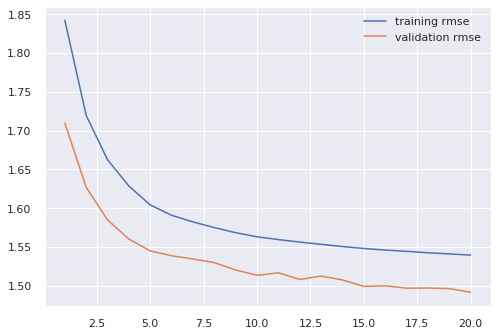

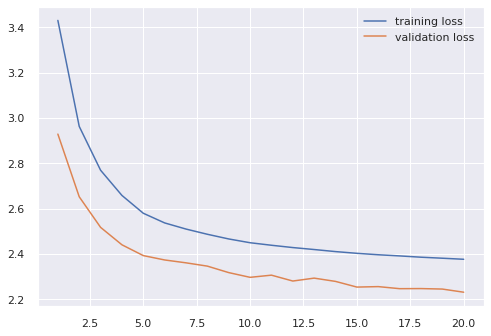

In [0]:
# display curves of loss and accuracy during training
acc = history.history['rmse']
val_acc = history.history['val_rmse']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)
plt.plot(epochs, acc, label='training rmse')
plt.plot(epochs, val_acc, label='validation rmse')
plt.legend()

plt.figure()
plt.plot(epochs, loss, label='training loss')
plt.plot(epochs, val_loss, label='validation loss')
plt.legend()
plt.show

# Test 

In [0]:
test = pd.read_csv(path_test)

In [0]:
test.head()

,row_id,building_id,meter,timestamp
0,0,0,0,2017-01-01 00:00:00
1,1,1,0,2017-01-01 00:00:00
2,2,2,0,2017-01-01 00:00:00
3,3,3,0,2017-01-01 00:00:00
4,4,4,0,2017-01-01 00:00:00


In [0]:
test.shape

(41697600, 4)

In [0]:
row_ids = test["row_id"]
test.drop("row_id", axis=1, inplace=True)
test = reduce_mem_usage(test)

Mem. usage decreased to 437.43 Mb (54.2% reduction)


In [0]:
test = test.merge(building, on=['building_id'], how='left')

In [0]:
test

,building_id,meter,timestamp,site_id,primary_use,square_feet
0,0,0,2017-01-01 00:00:00,0,0,7432
1,1,0,2017-01-01 00:00:00,0,0,2720
2,2,0,2017-01-01 00:00:00,0,0,5376
3,3,0,2017-01-01 00:00:00,0,0,23685
4,4,0,2017-01-01 00:00:00,0,0,116607
...,...,...,...,...,...,...
41697595,1444,0,2018-05-09 07:00:00,15,1,19619
41697596,1445,0,2018-05-09 07:00:00,15,0,4298
41697597,1446,0,2018-05-09 07:00:00,15,1,11265
41697598,1447,0,2018-05-09 07:00:00,15,4,29775


In [0]:
weather_df = pd.read_csv(path_weather_test)
weather_df = fill_weather_dataset(weather_df)
weather_df = reduce_mem_usage(weather_df)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  from ipykernel import kernelapp as app


Mem. usage decreased to  6.15 Mb (68.1% reduction)


In [0]:
test = test.merge(weather_df, on=['timestamp', 'site_id'], how='left')

In [0]:
test

,building_id,meter,timestamp,site_id,primary_use,square_feet,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2017-01-01 00:00:00,0,0,7432,17.796875,4.000000,11.703125,0.282715,1021.5,100.000,3.599609
1,1,0,2017-01-01 00:00:00,0,0,2720,17.796875,4.000000,11.703125,0.282715,1021.5,100.000,3.599609
2,2,0,2017-01-01 00:00:00,0,0,5376,17.796875,4.000000,11.703125,0.282715,1021.5,100.000,3.599609
3,3,0,2017-01-01 00:00:00,0,0,23685,17.796875,4.000000,11.703125,0.282715,1021.5,100.000,3.599609
4,4,0,2017-01-01 00:00:00,0,0,116607,17.796875,4.000000,11.703125,0.282715,1021.5,100.000,3.599609
...,...,...,...,...,...,...,...,...,...,...,...,...,...
41697595,1444,0,2018-05-09 07:00:00,15,1,19619,12.031250,1.727539,3.355469,-1.000000,1017.0,184.875,2.703125
41697596,1445,0,2018-05-09 07:00:00,15,0,4298,12.031250,1.727539,3.355469,-1.000000,1017.0,184.875,2.703125
41697597,1446,0,2018-05-09 07:00:00,15,1,11265,12.031250,1.727539,3.355469,-1.000000,1017.0,184.875,2.703125
41697598,1447,0,2018-05-09 07:00:00,15,4,29775,12.031250,1.727539,3.355469,-1.000000,1017.0,184.875,2.703125


In [0]:
###### scale fichier test

test.timestamp = pd.to_datetime(test.timestamp, format="%Y-%m-%d %H:%M:%S")
test['month'] = test['timestamp'].dt.month
test['day'] = test['timestamp'].dt.weekday
test['year'] = test['timestamp'].dt.year
test['hour'] = test['timestamp'].dt.hour

test['square_feet'] = test['square_feet'].astype('float32')
test['square_feet'] -= test['square_feet'].mean(axis=0)

std = test['square_feet'].std(axis=0)
test['square_feet'] /= test['square_feet'].std(axis=0)

weather_scale = ['air_temperature', 'cloud_coverage', 'dew_temperature', 'sea_level_pressure', 'wind_speed']
test[weather_scale] = test[weather_scale].astype('float32')
test[weather_scale] -= test[weather_scale].mean(axis=0)
std = test[weather_scale].std(axis=0)
test[weather_scale] /= test[weather_scale].std(axis=0)

test['wind_direction'+'_sin'] = np.sin((2*np.pi*test['wind_direction'])/360)
test['wind_direction'+'_cos'] = np.cos((2*np.pi*test['wind_direction'])/360)
test = test.drop(['wind_direction'], axis=1)

test.drop(['timestamp','year','hour'], axis= 1, inplace = True)

In [0]:
test

,building_id,meter,site_id,primary_use,square_feet,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_speed,month,day,wind_direction_sin,wind_direction_cos
0,0,0,0,0,-0.780344,0.448682,1.053375,0.415485,0.282715,2.669734,0.226331,1,6,0.984961,-0.172777
1,1,0,0,0,-0.823891,0.448682,1.053375,0.415485,0.282715,2.669734,0.226331,1,6,0.984961,-0.172777
2,2,0,0,0,-0.799345,0.448682,1.053375,0.415485,0.282715,2.669734,0.226331,1,6,0.984961,-0.172777
3,3,0,0,0,-0.630138,0.448682,1.053375,0.415485,0.282715,2.669734,0.226331,1,6,0.984961,-0.172777
4,4,0,0,0,0.228620,0.448682,1.053375,0.415485,0.282715,2.669734,0.226331,1,6,0.984961,-0.172777
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41697595,1444,0,15,1,-0.667715,-0.088537,-0.015481,-0.403610,-1.000000,2.642022,-0.210071,5,2,-0.083311,-0.996524
41697596,1445,0,15,0,-0.809307,-0.088537,-0.015481,-0.403610,-1.000000,2.642022,-0.210071,5,2,-0.083311,-0.996524
41697597,1446,0,15,1,-0.744920,-0.088537,-0.015481,-0.403610,-1.000000,2.642022,-0.210071,5,2,-0.083311,-0.996524
41697598,1447,0,15,4,-0.573856,-0.088537,-0.015481,-0.403610,-1.000000,2.642022,-0.210071,5,2,-0.083311,-0.996524


In [0]:
### reshape data for the LSTM architecture

#reshapeTest = test.values
#reshapeTest = reshapeTest.reshape((reshapeTest.shape[0], 1, reshapeTest.shape[1]))

In [0]:
# prediction = model.predict(test)

In [0]:
# prediction = np.expm1(prediction)